<a href="https://colab.research.google.com/github/Emil-KFU/NLP/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22fine_tune_bert_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Точная настройка модели BERT

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tfmodels/nlp/fine_tune_bert"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/models/blob/master/docs/nlp/fine_tune_bert.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/models/blob/master/docs/nlp/fine_tune_bert.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/models/docs/nlp/fine_tune_bert.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/collections/bert"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

В этом руководстве демонстрируется, как точно настроить представления двунаправленного кодера из модели Transformers (BERT) (Devlin et al., 2018) с использованием TensorFlow Model Garden.

Вы также можете найти предварительно обученную модель BERT, используемую в этом руководстве, на TensorFlow Hub (TF Hub). Конкретные примеры использования моделей из TF Hub см. в руководстве "Решайте задачи склеивания с помощью BERT". Если вы просто пытаетесь точно настроить модель, учебное пособие по TF Hub - хорошая отправная точка.

С другой стороны, если вы заинтересованы в более глубокой настройке, следуйте этому руководству. Здесь показано, как многое можно сделать вручную, чтобы вы могли узнать, как настроить рабочий процесс от предварительной обработки данных до обучения, экспорта и сохранения модели.saving the model.

## Настройка

### Установка пакетов pip

Начните с установки пакетов TensorFlow Text и Model Garden pip.

* tf-models-official является пакетом сада модели TensorFlow. Обратите внимание, что он может не включать последние изменения в репозитории tensorflow_modelsGitHub. Чтобы включить последние изменения, вы можете установить tf-models-nightly, который представляет собой пакет nightly Model Garden, создаваемый ежедневно автоматически.
*pip автоматически установит все модели и зависимости.

In [2]:
!pip install -q opencv-python

In [3]:
!pip install -q -U "tensorflow-text==2.9.*"

     |████████████████████████████████| 4.6 MB 35.0 MB/s 


In [4]:
!pip install -q tf-models-official

     |████████████████████████████████| 2.3 MB 31.6 MB/s 
     |████████████████████████████████| 588.3 MB 21 kB/s 
     |████████████████████████████████| 238 kB 67.8 MB/s 
     |████████████████████████████████| 43 kB 2.3 MB/s 
     |████████████████████████████████| 662 kB 69.5 MB/s 
     |████████████████████████████████| 1.1 MB 74.5 MB/s 
     |████████████████████████████████| 1.3 MB 60.3 MB/s 
     |████████████████████████████████| 118 kB 78.0 MB/s 
     |████████████████████████████████| 5.8 MB 66.4 MB/s 
     |████████████████████████████████| 352 kB 81.3 MB/s 
     |████████████████████████████████| 1.7 MB 75.3 MB/s 
     |████████████████████████████████| 6.0 MB 48.2 MB/s 
     |████████████████████████████████| 439 kB 56.2 MB/s 


### Импорт библиотек

In [5]:
import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_models as tfm
import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

### Ресурсы

Следующий каталог содержит конфигурацию модели BERT, словарь и предварительно подготовленную контрольную точку, используемую в этом руководстве:

In [6]:
gs_folder_bert = "gs://cloud-tpu-checkpoints/bert/v3/uncased_L-12_H-768_A-12"
tf.io.gfile.listdir(gs_folder_bert)

['bert_config.json',
 'bert_model.ckpt.data-00000-of-00001',
 'bert_model.ckpt.index',
 'vocab.txt']

## Загрузка и предварительная обработка набора данных

В этом примере используется набор данных GLUE (оценка общего понимания языка) MRPC (Microsoft Research Paraphrase Corpus) из <a>наборов данных TensorFlow (TFDS)</a>.Этот набор данных настроен не так, чтобы его можно было напрямую вводить в модель BERT. В следующем разделе рассматривается необходимая предварительная обработка..

Этот набор данных настроен не так, чтобы его можно было напрямую вводить в модель BERT. В следующем разделе рассматривается необходимая предварительная обработка.

### Получить набор данных из наборов данных TensorFlow

Набор данных GLUE MRPC (Dolan and Brockett, 2005) представляет собой набор пар предложений, автоматически извлекаемых из онлайн-источников новостей, с комментариями человека о том, являются ли предложения в паре семантически эквивалентными. Он имеет следующие атрибуты:

* Количество меток: 2
* Размер обучающего набора данных: 3668
* Размер набора данных для оценки: 408
* Максимальная длина последовательности обучающего и оценочного набора данных: 128

Начните с загрузки набора данных MRPC из TFDS:

In [7]:
batch_size=32
glue, info = tfds.load('glue/mrpc',
                       with_info=True,
                       batch_size=32)

Dataset glue downloaded and prepared to ~/tensorflow_datasets/glue/mrpc/2.0.0. Subsequent calls will reuse this data.


In [8]:
glue

{Split('train'): <PrefetchDataset element_spec={'idx': TensorSpec(shape=(None,), dtype=tf.int32, name=None), 'label': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'sentence1': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'sentence2': TensorSpec(shape=(None,), dtype=tf.string, name=None)}>,
 Split('validation'): <PrefetchDataset element_spec={'idx': TensorSpec(shape=(None,), dtype=tf.int32, name=None), 'label': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'sentence1': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'sentence2': TensorSpec(shape=(None,), dtype=tf.string, name=None)}>,
 Split('test'): <PrefetchDataset element_spec={'idx': TensorSpec(shape=(None,), dtype=tf.int32, name=None), 'label': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'sentence1': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'sentence2': TensorSpec(shape=(None,), dtype=tf.string, name=None)}>}

Объект `info` описывает набор данных и его функции:

In [9]:
info.features

FeaturesDict({
    'idx': tf.int32,
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    'sentence1': Text(shape=(), dtype=tf.string),
    'sentence2': Text(shape=(), dtype=tf.string),
})

Два класса такие:

In [10]:
info.features['label'].names

['not_equivalent', 'equivalent']

Вот один пример из обучающего набора:

In [11]:
example_batch = next(iter(glue['train']))

for key, value in example_batch.items():
  print(f"{key:9s}: {value[0].numpy()}")

idx      : 1680
label    : 0
sentence1: b'The identical rovers will act as robotic geologists , searching for evidence of past water .'
sentence2: b'The rovers act as robotic geologists , moving on six wheels .'


### Предварительная обработка данных

Ключи `"sentence1"`и `"sentence2"` в наборе данных GLUE MRPC содержат два входных предложения для каждого примера.

Поскольку модель BERT из Model Garden не принимает необработанный текст в качестве входных данных, сначала должны произойти две вещи:

1. Текст должен быть маркирован (разбит на части слов) и преобразован в индексы.
2. Затем индексы должны быть упакованы в формат, который ожидает модель.

#### Токенизатор БЕРТА

Чтобы точно настроить предварительно подготовленную языковую модель из Model Garden, такую как BERT, вам необходимо убедиться, что вы используете точно такую же маркировку, словарь и сопоставление индексов, которые использовались во время обучения.

Следующий код перестраивает токенизатор, который использовался базовой моделью, используя `tfm.nlp.layers.FastWordpieceBertTokenizer` слой модели Garden:

In [12]:
tokenizer = tfm.nlp.layers.FastWordpieceBertTokenizer(
    vocab_file=os.path.join(gs_folder_bert, "vocab.txt"),
    lower_case=True)

Давайте протокенизируем тестовое предложение:

In [13]:
tokens = tokenizer(tf.constant(["Hello TensorFlow!"]))
tokens

<tf.RaggedTensor [[[7592], [23435, 12314], [999]]]>

#### Упакуем входные данные

Модель BERT TensorFlow модели Garden не просто принимает маркированные строки в качестве входных данных. Он также ожидает, что они будут упакованы в определенный формат. `tfm.nlp.layers.BertPackInputs` слой может обрабатывать преобразование из списка маркированных предложений во входной формат, ожидаемый моделью BERT в Model Garden.

`tfm.nlp.layers.BertPackInputs` объединяет два входных предложения (для каждого примера в наборе данных MRCP), объединенные вместе. Ожидается, что этот ввод будет начинаться с токена [CLS]"Это проблема классификации", и каждое предложение должно заканчиваться токеном [SEP]"Разделитель".

Поэтому конструктор `tfm.nlp.layers.BertPackInputs` слоя принимает специальные токены `tokenizer` в качестве аргумента. Также необходимо знать индексы специальных токенов токенизатора.

In [14]:
special = tokenizer.get_special_tokens_dict()
special

{'vocab_size': 30522,
 'start_of_sequence_id': 101,
 'end_of_segment_id': 102,
 'padding_id': 0,
 'mask_id': 103}

In [15]:
max_seq_length = 128

packer = tfm.nlp.layers.BertPackInputs(
    seq_length=max_seq_length,
    special_tokens_dict = tokenizer.get_special_tokens_dict())

В `packer` качестве входных данных используется список маркированных предложений. Например:

In [16]:
sentences1 = ["hello tensorflow"]
tok1 = tokenizer(sentences1)
tok1

<tf.RaggedTensor [[[7592], [23435, 12314]]]>

In [17]:
sentences2 = ["goodbye tensorflow"]
tok2 = tokenizer(sentences2)
tok2

<tf.RaggedTensor [[[9119], [23435, 12314]]]>

Затем он возвращает словарь, содержащий три выходных данных:

- `input_word_ids`: Токенизированные предложения упакованные вместе.
- `input_mask`: Маска, указывающая, какие местоположения допустимы в других выходных данных.
- `input_type_ids`: Указание на то, к какому предложению относится каждый токен.

In [18]:
packed = packer([tok1, tok2])

for key, tensor in packed.items():
  print(f"{key:15s}: {tensor[:, :12]}")

input_word_ids : [[  101  7592 23435 12314   102  9119 23435 12314   102     0     0     0]]
input_mask     : [[1 1 1 1 1 1 1 1 1 0 0 0]]
input_type_ids : [[0 0 0 0 0 1 1 1 1 0 0 0]]


####  Соберём все это вместе
Объедините эти две части в `keras.layers.Layer` который может быть прикреплён к нашей модеои

In [19]:
class BertInputProcessor(tf.keras.layers.Layer):
  def __init__(self, tokenizer, packer):
    super().__init__()
    self.tokenizer = tokenizer
    self.packer = packer

  def call(self, inputs):
    tok1 = self.tokenizer(inputs['sentence1'])
    tok2 = self.tokenizer(inputs['sentence2'])

    packed = self.packer([tok1, tok2])

    if 'label' in inputs:
      return packed, inputs['label']
    else:
      return packed

Но пока просто примените его к используемому набору `Dataset.map` данных, поскольку набор данных, который вы загрузили из TFDS, является `tf.data.Dataset` объектом:

In [20]:
bert_inputs_processor = BertInputProcessor(tokenizer, packer)

In [21]:
glue_train = glue['train'].map(bert_inputs_processor).prefetch(1)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Вот пример пакета из обработанного набора данных:

In [22]:
example_inputs, example_labels = next(iter(glue_train))

In [23]:
example_inputs

{'input_word_ids': <tf.Tensor: shape=(32, 128), dtype=int32, numpy=
 array([[ 101, 1996, 7235, ...,    0,    0,    0],
        [ 101, 2625, 2084, ...,    0,    0,    0],
        [ 101, 6804, 1011, ...,    0,    0,    0],
        ...,
        [ 101, 2021, 2049, ...,    0,    0,    0],
        [ 101, 2274, 2062, ...,    0,    0,    0],
        [ 101, 2043, 1037, ...,    0,    0,    0]], dtype=int32)>,
 'input_mask': <tf.Tensor: shape=(32, 128), dtype=int32, numpy=
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>,
 'input_type_ids': <tf.Tensor: shape=(32, 128), dtype=int32, numpy=
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>}

In [24]:
example_labels

<tf.Tensor: shape=(32,), dtype=int64, numpy=
array([0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 0, 1])>

In [25]:
for key, value in example_inputs.items():
  print(f'{key:15s} shape: {value.shape}')

print(f'{"labels":15s} shape: {example_labels.shape}')

input_word_ids  shape: (32, 128)
input_mask      shape: (32, 128)
input_type_ids  shape: (32, 128)
labels          shape: (32,)


`input_word_ids` содержит ID токенов:

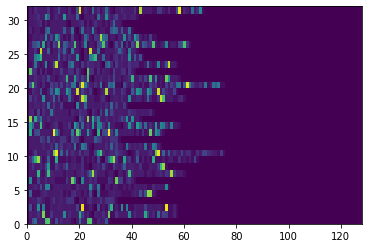

In [26]:
plt.pcolormesh(example_inputs['input_word_ids'])

Маска позволяет модели четко различать содержимое и заполнение. Маска имеет ту же форму, что и `input_word_ids` и содержит `1` в любом месте `input_word_id` не заполнение.

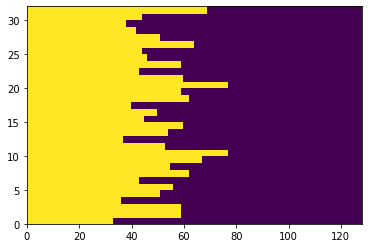

In [27]:
plt.pcolormesh(example_inputs['input_mask'])

"Тип ввода" также имеет ту же форму, но внутри области без заполнения содержит `0` или `1`, указывающее, частью какого предложения является токен.

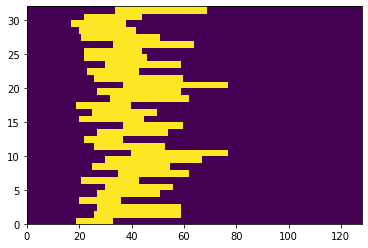

In [28]:
plt.pcolormesh(example_inputs['input_type_ids'])

Примените ту же предварительную обработку к подмножествам проверки и тестирования набора данных GLUE MRPC:

In [29]:
glue_validation = glue['validation'].map(bert_inputs_processor).prefetch(1)
glue_test = glue['test'].map(bert_inputs_processor).prefetch(1)

## Создание, обучение и экспорт модели

Теперь, когда вы отформатировали данные, как ожидалось, вы можете начать работать над созданием и обучением модели.

### Строим модель


Первый шаг - загрузить файл конфигурации `config_dict` для предварительно обученной модели BERT:


In [30]:
import json

bert_config_file = os.path.join(gs_folder_bert, "bert_config.json")
config_dict = json.loads(tf.io.gfile.GFile(bert_config_file).read())
config_dict

{'attention_probs_dropout_prob': 0.1,
 'hidden_act': 'gelu',
 'hidden_dropout_prob': 0.1,
 'hidden_size': 768,
 'initializer_range': 0.02,
 'intermediate_size': 3072,
 'max_position_embeddings': 512,
 'num_attention_heads': 12,
 'num_hidden_layers': 12,
 'type_vocab_size': 2,
 'vocab_size': 30522}

In [31]:
encoder_config = tfm.nlp.encoders.EncoderConfig({
    'type':'bert',
    'bert': config_dict
})

In [32]:
bert_encoder = tfm.nlp.encoders.build_encoder(encoder_config)
bert_encoder

Файл конфигурации определяет основную модель BERT из набора моделей, которая представляет собой модель Keras, которая прогнозирует выходные ` num_classes` данные из входных данных с максимальной длиной последовательности `max_seq_length.`

In [33]:
bert_classifier = tfm.nlp.models.BertClassifier(network=bert_encoder, num_classes=2)

 Классификатор имеет три входа и один выход

Запустите его на тестовом пакете данных 10 примеров из обучающего набора. Выходные данные представляют собой логарифмы для двух классов:

In [34]:
bert_classifier(
    example_inputs, training=True).numpy()[:10]

array([[-0.35612246,  0.38786787],
       [-0.83782256,  0.84094346],
       [-0.46177948,  1.3095294 ],
       [ 0.3219787 ,  0.7223166 ],
       [ 0.78034693,  1.4243224 ],
       [ 0.01892626,  0.70761883],
       [-0.32131878,  1.0703396 ],
       [-0.368509  ,  0.9295537 ],
       [-0.44048637,  0.57964224],
       [-0.36098316,  1.0564027 ]], dtype=float32)

`TransformerEncoder` в центре приведенного выше классификатора это `bert_encoder.`

Если вы проверите кодировщик, обратите внимание что стопка `Transformer` слоев, подключена к тем же трем входам:

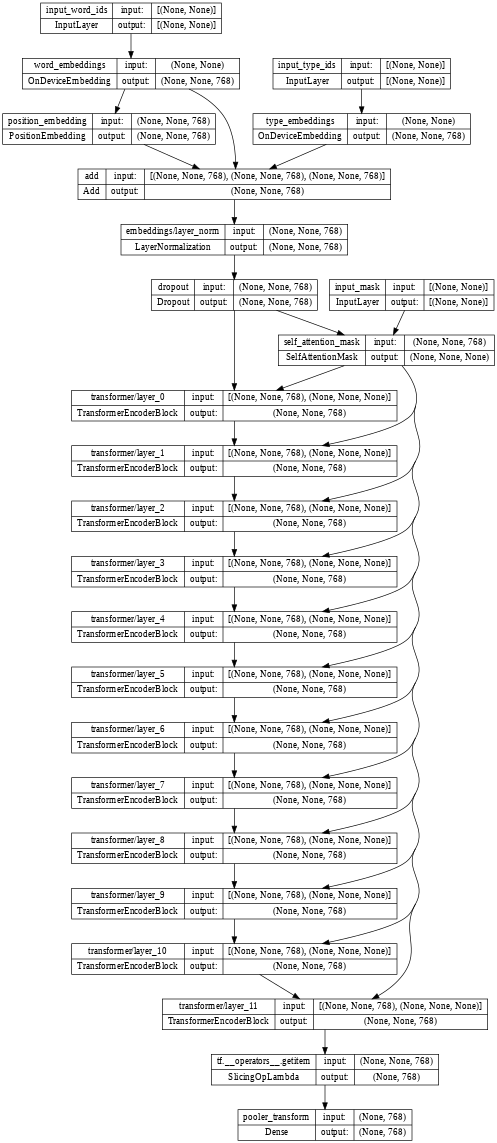

In [35]:
tf.keras.utils.plot_model(bert_encoder, show_shapes=True, dpi=48)

### Восстановим веса кодировщика

При построении кодировщик инициализируется случайным образом. Восстановление весов кодировщика из контрольной точки:

In [36]:
checkpoint = tf.train.Checkpoint(encoder=bert_encoder)
checkpoint.read(
    os.path.join(gs_folder_bert, 'bert_model.ckpt')).assert_consumed()

### Настройка оптимизатора
BERT обычно использует оптимизатор Adam с уменьшением веса—AdamW (`tf.keras.optimizers.experimental.AdamW`). Он также использует график скорости обучения, который сначала увеличивается с 0, а затем уменьшается до 0:

In [37]:
# Set up epochs and steps
epochs = 5
batch_size = 32
eval_batch_size = 32

train_data_size = info.splits['train'].num_examples
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(0.1 * num_train_steps)
initial_learning_rate=2e-5

Линейное затухание `initial_learning_rate` до нуля за `num_train_steps`.

In [38]:
linear_decay = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=initial_learning_rate,
    end_learning_rate=0,
    decay_steps=num_train_steps)

Разогрев до этого значения за `warmup_steps`:

In [39]:
warmup_schedule = tfm.optimization.lr_schedule.LinearWarmup(
    warmup_learning_rate = 0,
    after_warmup_lr_sched = linear_decay,
    warmup_steps = warmup_steps
)

Общий график выглядит так:

Text(0, 0.5, 'Learning rate')

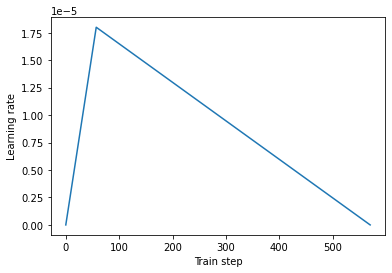

In [40]:
x = tf.linspace(0, num_train_steps, 1001)
y = [warmup_schedule(xi) for xi in x]
plt.plot(x,y)
plt.xlabel('Train step')
plt.ylabel('Learning rate')

Используем `tf.keras.optimizers.experimental.AdamW` чтобы создать экземпляр оптимизатора с этим графиком:

In [41]:
optimizer = tf.keras.optimizers.experimental.Adam(
    learning_rate = warmup_schedule)

### Обучение модели

Задайте метрику как точность, а потери как разреженную категориальную кросс-энтропию. Затем скомпилируйте и обучите классификатор BERT:

In [42]:
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)]
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

bert_classifier.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics)

In [43]:
bert_classifier.evaluate(glue_validation)

13/13 [==============================] - 6s 266ms/step - loss: 0.7299 - accuracy: 0.6838


[0.729893684387207, 0.6838235259056091]

In [44]:
bert_classifier.fit(
      glue_train,
      validation_data=(glue_validation),
      batch_size=32,
      epochs=epochs)

Epoch 1/5
115/115 [==============================] - 135s 855ms/step - loss: 0.6448 - accuracy: 0.6887 - val_loss: 0.4897 - val_accuracy: 0.7721
Epoch 2/5
115/115 [==============================] - 99s 863ms/step - loss: 0.4011 - accuracy: 0.8252 - val_loss: 0.4944 - val_accuracy: 0.8113
Epoch 3/5
115/115 [==============================] - 98s 852ms/step - loss: 0.2203 - accuracy: 0.9147 - val_loss: 0.4662 - val_accuracy: 0.8333
Epoch 4/5
115/115 [==============================] - 99s 864ms/step - loss: 0.0986 - accuracy: 0.9692 - val_loss: 0.5609 - val_accuracy: 0.8211
Epoch 5/5
115/115 [==============================] - 98s 851ms/step - loss: 0.0545 - accuracy: 0.9869 - val_loss: 0.5190 - val_accuracy: 0.8333


Теперь запустите точно настроенную модель на пользовательском примере, чтобы убедиться, что она работает.

Начните с кодирования некоторых пар предложений:

In [45]:
my_examples = {
        'sentence1':[
            'The rain in Spain falls mainly on the plain.',
            'Look I fine tuned BERT.'],
        'sentence2':[
            'It mostly rains on the flat lands of Spain.',
            'Is it working? This does not match.']
    }

Модель должна сообщать о классе 1 "match" для первого примера и классе 0 "no-match" для второго:

In [46]:
ex_packed = bert_inputs_processor(my_examples)
my_logits = bert_classifier(ex_packed, training=False)

result_cls_ids = tf.argmax(my_logits)
result_cls_ids

<tf.Tensor: shape=(2,), dtype=int64, numpy=array([1, 0])>

In [47]:
tf.gather(tf.constant(info.features['label'].names), result_cls_ids)

<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'equivalent', b'not_equivalent'], dtype=object)>

### Экспорт модели

Часто целью обучения модели является использование ее для чего-то вне процесса Python, который ее создал. Вы можете сделать это, экспортировав модель с помощью `tf.saved_model.`

Сначала создайте класс-оболочку для экспорта модели. Эта оболочка выполняет две вещи:

- Во-первых, она упаковывает `bert_inputs_processor` и `bert_classifier` вместе в один `tf.Module`, чтобы мы могли экспортировать все функциональные возможности.
- Во-вторых, она определяет `tf.function`, которая реализует сквозное выполнение модели.

Установка аргумента `input_signature` `tf.function`позволяет определить фиксированную сигнатуру для `tf.function`. Это может быть менее неожиданным, чем поведение автоматического восстановления по умолчанию.

In [48]:
class ExportModel(tf.Module):
  def __init__(self, input_processor, classifier):
    self.input_processor = input_processor
    self.classifier = classifier

  @tf.function(input_signature=[{
      'sentence1': tf.TensorSpec(shape=[None], dtype=tf.string),
      'sentence2': tf.TensorSpec(shape=[None], dtype=tf.string)}])
  def __call__(self, inputs):
    packed = self.input_processor(inputs)
    logits =  self.classifier(packed, training=False)
    result_cls_ids = tf.argmax(logits)
    return {
        'logits': logits,
        'class_id': result_cls_ids,
        'class': tf.gather(
            tf.constant(info.features['label'].names),
            result_cls_ids)
    }

Создайте экземпляр этой экспортной модели и сохраните его:

In [49]:
export_model = ExportModel(bert_inputs_processor, bert_classifier)

In [50]:
import tempfile
export_dir=tempfile.mkdtemp(suffix='_saved_model')
tf.saved_model.save(export_model, export_dir=export_dir,
                    signatures={'serving_default': export_model.__call__})

Перезагрузите модель и сравните результаты с оригиналом:

In [51]:
original_logits = export_model(my_examples)['logits']

In [52]:
reloaded = tf.saved_model.load(export_dir)
reloaded_logits = reloaded(my_examples)['logits']

In [53]:
# The results are identical:
print(original_logits.numpy())
print()
print(reloaded_logits.numpy())

[[-2.455573   1.9706666]
 [ 1.5132495 -1.2756969]]

[[-2.455573   1.9706666]
 [ 1.5132495 -1.2756969]]


In [54]:
print(np.mean(abs(original_logits - reloaded_logits)))

0.0


Поздравляем! Вы использовали `tensorflow_models` для создания BERT-классификатора, его обучения и экспорта для последующего использования.

## Дополнительно: BERT на TF Hub

<a id="hub_bert"></a>


Вы можете получить готовую модель BERT из TF Hub. Доступно множество версий вместе с их препроцессорами ввода.

В этом примере используется уменьшенная версия BERT из TF Hub, которая была предварительно обучена с использованием наборов данных английской Википедии и BooksCorpus, аналогично исходной реализации (Turc et al., 2019).

Начните с импорта TF Hub:

In [55]:
import tensorflow_hub as hub

Выберите предварительный обработчик (препроцессор) входа и модель из TF Hub и оберните их в виде `hub.KerasLayer` слоев:

In [56]:
# Всегда проверяйте, что ииспользуете правильный предварительный обработчик
hub_preprocessor = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")

# Это действительно маленький BERT.
hub_encoder = hub.KerasLayer(f"https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/2",
                             trainable=True)

print(f"The Hub encoder has {len(hub_encoder.trainable_variables)} trainable variables")

The Hub encoder has 39 trainable variables


Тестовый запуск препроцессора для пакета данных:

In [57]:
hub_inputs = hub_preprocessor(['Hello TensorFlow!'])
{key: value[0, :10].numpy() for key, value in hub_inputs.items()} 

{'input_word_ids': array([  101,  7592, 23435, 12314,   999,   102,     0,     0,     0,
            0], dtype=int32),
 'input_type_ids': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32),
 'input_mask': array([1, 1, 1, 1, 1, 1, 0, 0, 0, 0], dtype=int32)}

In [58]:
result = hub_encoder(
    inputs=hub_inputs,
    training=False,
)

print("Pooled output shape:", result['pooled_output'].shape)
print("Sequence output shape:", result['sequence_output'].shape)

Pooled output shape: (1, 128)
Sequence output shape: (1, 128, 128)


На этом этапе было бы просто добавить классификационный заголовок самостоятельно.

Класс Model Garden `tfm.nlp.models.BertClassifier` также может встроить классификатор в кодировщик TF Hub:

In [59]:
hub_classifier = tfm.nlp.models.BertClassifier(
    bert_encoder,
    num_classes=2,
    dropout_rate=0.1,
    initializer=tf.keras.initializers.TruncatedNormal(
        stddev=0.02))

Единственным недостатком загрузки этой модели из TF Hub является то, что структура внутренних слоев Keras не восстанавливается. Это затрудняет проверку или модификацию модели.

Модель кодировщика BERT -`hub_classifier`-теперь представляет собой один слой:

## Дополнительно: конфигурация оптимизатора

Пакет `tensorflow_models` определяет сериализуемые классы `config`, которые описывают, как строить live-объекты. Ранее в этом руководстве вы строили оптимизатор вручную.

Конфигурация ниже описывает почти идентичный оптимизатор, построенный `optimizer_factory.OptimizerFactory`:

In [60]:
optimization_config = tfm.optimization.OptimizationConfig(
    optimizer=tfm.optimization.OptimizerConfig(
        type = "adam"),
    learning_rate = tfm.optimization.LrConfig(
        type='polynomial',
        polynomial=tfm.optimization.PolynomialLrConfig(
            initial_learning_rate=2e-5,
            end_learning_rate=0.0,
            decay_steps=num_train_steps)),
    warmup = tfm.optimization.WarmupConfig(
        type='linear',
        linear=tfm.optimization.LinearWarmupConfig(warmup_steps=warmup_steps)
    ))


fac = tfm.optimization.optimizer_factory.OptimizerFactory(optimization_config)
lr = fac.build_learning_rate()
optimizer = fac.build_optimizer(lr=lr)

Text(0, 0.5, 'Learning rate')

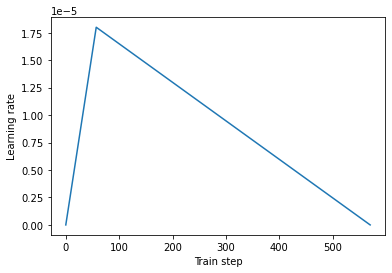

In [61]:
x = tf.linspace(0, num_train_steps, 1001).numpy()
y = [lr(xi) for xi in x]
plt.plot(x,y)
plt.xlabel('Train step')
plt.ylabel('Learning rate')

Преимущество использования `config` объектов заключается в том, что они не содержат каких-либо сложных объектов TensorFlow и могут быть легко сериализованы в JSON и перестроены. Вот JSON для приведенного выше `tfm.optimization.OptimizationConfig:`

In [62]:
optimization_config = optimization_config.as_dict()
optimization_config

{'optimizer': {'type': 'adam',
  'adam': {'clipnorm': None,
   'clipvalue': None,
   'global_clipnorm': None,
   'name': 'Adam',
   'beta_1': 0.9,
   'beta_2': 0.999,
   'epsilon': 1e-07,
   'amsgrad': False}},
 'ema': None,
 'learning_rate': {'type': 'polynomial',
  'polynomial': {'name': 'PolynomialDecay',
   'initial_learning_rate': 2e-05,
   'decay_steps': 570,
   'end_learning_rate': 0.0,
   'power': 1.0,
   'cycle': False,
   'offset': 0}},
 'warmup': {'type': 'linear',
  'linear': {'name': 'linear', 'warmup_learning_rate': 0, 'warmup_steps': 57}}}

`tfm.optimization.optimizer_factory.OptimizerFactory` так же легко может создать оптимизатор из словаря JSON:

In [63]:
fac = tfm.optimization.optimizer_factory.OptimizerFactory(
    tfm.optimization.OptimizationConfig(optimization_config))
lr = fac.build_learning_rate()
optimizer = fac.build_optimizer(lr=lr)